In [195]:
#IMPORTING ALL THE DEPENDENCIES
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input,add
from keras.layers.core import Dense,Layer,Activation,Lambda,Reshape,Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D,UpSampling2D,ZeroPadding2D
from keras.utils import np_utils,to_categorical
from keras import backend as K
from keras import metrics

In [236]:
#IMPORTING ALL THE DEPENDENCIES FOR PROCESSING THE DATA

from scipy.misc import imread,imshow,imresize
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from keras.models import Model,load_model
from keras.objectives import binary_crossentropy
import cv2
from keras.callbacks import EarlyStopping,ModelCheckpoint


In [197]:
#GETTING ALL THE LABELS FROM THE DIRECTORY IN WHICH THE IMAGES ARE SITUATED
temp1=[]
for dirpath,dire,fnames in os.walk('/Users/Pradeep/Desktop/lfw_funneled/'):
    for i in range(len(fnames)):
        if fnames[i].endswith('.jpg') :
            y=os.path.basename(dirpath)
            temp1.append(y)


In [ ]:
#GETTING ALL THE IMAGES FROM THE DIRECTORY OF THE DATA

temp=[]
for dirpath,dire,filenames in os.walk('/Users/Pradeep/Desktop/lfw_funneled/'):
    for i in range(len(filenames)):
        if filenames[i].endswith('.jpg') :
            dr=os.path.join(os.getcwd(),os.path.join(dirpath,filenames[i]))
            img=imread(dr)
            img=imresize(img,(64,64))
            img=img.astype('float32')/255.            
            
            temp.append(img)
Xtrain=np.stack(temp)   
np.save('lfw.npy',Xtrain)

In [4]:
Images=np.load('lfw.npy')


In [27]:
#ENCODING ALL THE LABELS INTO NUMBERS AND ONE-HOT-ENCODING THEM
names=np.asarray(temp1)
lb=LabelEncoder()
oh=OneHotEncoder()
y=lb.fit_transform(names)
y=y.reshape(y.shape[0],1)
EncodedLabels=oh.fit_transform(y)


In [199]:
#AUGMENTING THE TRAINING DATA

Xflip=Images[:, :, ::-1]
AugImages=np.concatenate((Images,Xflip),axis=0)
AugImages.shape

(26466, 64, 64, 3)

11329
Scott_Hamilton


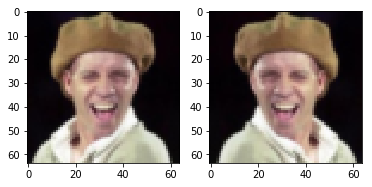

In [220]:
#PLOTTING A RANDOM IMAGE FROM THE ORIGINAL AND AUGMENTED DATA
j=np.random.randint(0,Xflip.shape[0])
print(j)
plt.subplot(121)
plt.imshow(Xflip[j],cmap='gray')
plt.subplot(122)
plt.imshow(Images[j],cmap='gray')
print(temp1[j])

In [237]:
checkpoint=ModelCheckpoint("weights-imporovement-{epoch:02d}-{val_acc:.2f}.hdf5",
                           monitor='val_loss',verbose=1,save_best_only=True,mode='auto')
esm=EarlyStopping(monitor='val_loss',patience=2)


In [215]:
from sklearn.model_selection import train_test_split
Xtrain,Xval,Ytrain,Yval=train_test_split(AugImages,AugImages,test_size=0.05,random_state=451)

In [242]:
#DEFINING THE MODEL

latent=6
std=1.0

x=Input(shape=(64,64,3))
# Encoder
conv1_1 = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1_1)
flat=Flatten()(pool1)
z_mean=Dense(latent)(flat)
z_var=Dense(latent)(flat)

z = Lambda(samp, output_shape=(latent,))([z_mean, z_var])


#Decoder
flat1=Dense(32,activation='relu')
flat11=flat1(z)
flat2=Dense(256,activation='relu')
flat22=flat2(flat11)
flatd=Dense(8192,activation='relu')
flatdd=flatd(flat22)
res=Reshape((32,32,8))
resh=res(flatdd)
ups=UpSampling2D((2,2))
upss=ups(resh)
xdecode=Conv2D(3,(3,3),activation='relu',padding='same')
xdecoded=xdecode(upss)

lfw=Model(input=x,outputs=xdecoded)
lfw.summary()
lfw.compile(optimizer='adadelta', loss=vae_loss)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 64, 64, 8)    224         input_18[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, 32, 32, 8)    0           conv2d_34[0][0]                  
__________________________________________________________________________________________________
flatten_17 (Flatten)            (None, 8192)         0           max_pooling2d_17[0][0]           
__________________________________________________________________________________________________
dense_55 (

C:\Users\Pradeep\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


In [55]:
#DEFINING THE SAMPLING PROCESS AND THE VARIATIONAL LOSS

def samp(args):
    z_mean,z_var=args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent), mean=0., stddev=std)
    return z_mean + K.exp(z_var / 2) * epsilon 


def vae_loss(x, xdecoded):
    xent_loss = 784* binary_crossentropy(K.flatten(x),K.flatten(xdecoded))
    kl_loss = - 0.5 * K.sum(1 + z_var - K.square(z_mean) - K.exp(z_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

In [243]:
history = lfw.fit(Xtrain, Ytrain,shuffle=True, epochs=5 ,batch_size=128, callbacks=[esm],validation_data=(Xval, Yval))

Train on 25142 samples, validate on 1324 samples
Epoch 1/5
25142/25142 [==============================] - 89s 4ms/step - loss: 591.6000 - val_loss: 611.1116
Epoch 2/5
25142/25142 [==============================] - 52s 2ms/step - loss: 486.9440 - val_loss: 478.8943
Epoch 3/5
25142/25142 [==============================] - 50s 2ms/step - loss: 469.6112 - val_loss: 467.9518
Epoch 4/5
25142/25142 [==============================] - 50s 2ms/step - loss: 464.4677 - val_loss: 462.8957
Epoch 5/5
25142/25142 [==============================] - 50s 2ms/step - loss: 461.9423 - val_loss: 457.3723


In [244]:
#BUILDING a GENERATOR THAN CAN SAMPLE FROM THE LEARNED DISTRIBUTION
decoder_input = Input(shape=(latent,))
flat11=flat1(decoder_input)
flat22=flat2(flat11)
h_decoded = flatd(flat22)
reshaped= res(h_decoded)
upsampled =ups(reshaped)
genx=xdecode(upsampled)
generator = Model(decoder_input, genx)

In [246]:
generator.save('lfwgenweights.h5')

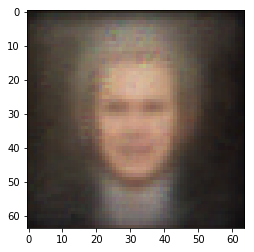

In [307]:
a=np.random.normal(size=(6,1))
x_decoded = generator.predict(a.T)
plt.imshow(x_decoded[0])